# Topic 1: Price Forecast - Avocado

### Yêu cầu 3: Dự Đoán Giá Conventional Avocado tại California

Sau khi đã thực hiện mô hình regression dự đoán giá bơ cho cả nước Mỹ và xem xu hướng giá bơ organic tại California, chúng ta đã có những hiểu biết nhất định về bộ dữ liệu. Việc tiếp theo chúng ta sẽ làm là xem xét cụ thể loại bơ conventional tại California để xem mô hình regression nào phù hợp để đoán giá "cục bộ" có khác gì khi chúng ta làm trên toàn nước Mỹ ko, cũng như tìm hiểu xem tiềm năng phát triển kinh doanh của loại bơ conventional tại California như thế nào.

## Triển Khai Dự Án

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt

from sklearn.pipeline import  Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.float_format = '{:.2f}'.format

In [3]:
data = pd.read_csv('avocado.csv', index_col=0)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18249 entries, 0 to 11
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          18249 non-null  object 
 1   AveragePrice  18249 non-null  float64
 2   Total Volume  18249 non-null  float64
 3   4046          18249 non-null  float64
 4   4225          18249 non-null  float64
 5   4770          18249 non-null  float64
 6   Total Bags    18249 non-null  float64
 7   Small Bags    18249 non-null  float64
 8   Large Bags    18249 non-null  float64
 9   XLarge Bags   18249 non-null  float64
 10  type          18249 non-null  object 
 11  year          18249 non-null  int64  
 12  region        18249 non-null  object 
dtypes: float64(9), int64(1), object(3)
memory usage: 1.9+ MB


In [5]:
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.00,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.00,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.00,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.00,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.00,conventional,2015,Albany


## Regression: Bài Toán Dự Đoán Giá Conventional Avocado tại California


###  Data Preparation / Prepare

#### các bước EDA đã thực hiện bài trước không cần làm lại

In [6]:
df = data.copy()

In [7]:
df = df[(df['region'] == 'California') & (df['type'] == 'conventional')]
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California


### Feature Engineering

có thể xem xét yếu tố mùa xuân hạ thu đông có ảnh hưởng đến AveragePrice
- mùa xuân: tháng 3,4,5
- mùa hạ: tháng 6,7,8
- mùa thu: tháng 9,10,11
- mùa đông: tháng 12,1,2

In [8]:
#chuyển dữ liệu biến Date về kiểu datetime
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
#tạo ra cột Month
df['Month'] = pd.DatetimeIndex(df['Date']).month
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California,12
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California,12
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California,12
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California,12
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California,11


In [10]:
def to_season(month):
    if month >= 3 and month <= 5:
        return 0
    elif month >= 6 and month <= 8:
        return 1
    elif month >= 9 and month <= 11:
        return 2
    else:
        return 3

In [11]:
#tạo ra cột Season
df['Season'] = df['Month'].apply(lambda x: to_season(x))

In [12]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Season
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California,12,3
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California,12,3
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California,12,3
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California,12,3
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California,11,2


#### Như chúng ta đã hiểu khi phân tích cho cả nước Mỹ, các yếu tố về năm, tháng, season có ảnh hưởng đến AveragePrice, và chúng ta cũng loại những biến đa cộng tuyến chỉ giữ lại Total Volume và Total Bags để đưa vào mô hình dự đoán giá </span>

In [17]:
#lựa chọn thuộc tính, bỏ đi các thuộc tính dư thừa
y = df['AveragePrice']
X = df.drop(['Date','AveragePrice','region','type','4046','4225','4770','Small Bags','Large Bags','XLarge Bags'], axis=1)

In [18]:
X.head()

,Total Volume,Total Bags,year,Month,Season
0,5040365.47,1212707.01,2015,12,3
1,4695737.21,1209165.20,2015,12,3
2,5259354.30,1592438.33,2015,12,3
3,5775536.27,1510267.34,2015,12,3
4,4575710.62,1081497.47,2015,11,2


### Modeling & Evaluation / Analyze & Report

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

trước đó chúng ta đã biết RandomForestRegressor, XGBRegressor, BaggingRegressor là những mô hình phù hợp cho việc dự đoán giá bơ trên toàn nước Mỹ, chúng ta sẽ đi kiểm nghiệm lại xem những mô hình này có phù hợp với việc dự đoán giá "cục bộ" cho loại conventional ở California không

#### Dùng RandomForestRegressor

In [21]:
pipe_RF = Pipeline([('scaler', StandardScaler()), ('rf', RandomForestRegressor())])
pipe_RF.fit(X_train, y_train)
y_pred_RF = pipe_RF.predict(X_test)
mae_RF = mean_absolute_error(y_test, y_pred_RF)
r2_RF = r2_score(y_test, y_pred_RF)
train_RF = pipe_RF.score(X_train,y_train)
test_RF = pipe_RF.score(X_test,y_test)

#### Dùng XGBRegressor

In [22]:
pipe_XGB = Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor())])
pipe_XGB.fit(X_train, y_train)
y_pred_XGB = pipe_XGB.predict(X_test)
mae_XGB = mean_absolute_error(y_test, y_pred_XGB)
r2_XGB = r2_score(y_test, y_pred_XGB)
train_XGB = pipe_XGB.score(X_train,y_train)
test_XGB = pipe_XGB.score(X_test,y_test)

#### Dùng BaggingRegressor

In [23]:
# importing bagging module
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb

In [28]:
pipe_BAG = Pipeline([('scaler', StandardScaler()), ('bag', BaggingRegressor(base_estimator=xgb.XGBRegressor()))])
pipe_BAG.fit(X_train, y_train)
y_pred_BAG = pipe_BAG.predict(X_test)
mae_BAG = mean_absolute_error(y_test, y_pred_BAG)
r2_BAG = r2_score(y_test, y_pred_BAG)
train_BAG = pipe_BAG.score(X_train,y_train)
test_BAG = pipe_BAG.score(X_test,y_test)

In [29]:
scoring = pd.DataFrame({"algorithm":['RandomForestRegressor', 'XGBRegressor', 'BaggingRegressor'],
                        "score train":[train_RF, train_XGB, train_BAG], 
                        "score test":[test_RF, test_XGB, test_BAG],
                        "R2 score":[r2_RF, r2_XGB, r2_BAG],
                        "MAE":[mae_RF, mae_XGB, mae_BAG]})
scoring

,algorithm,score train,score test,R2 score,MAE
0,RandomForestRegressor,0.98,0.88,0.88,0.05
1,XGBRegressor,1.00,0.91,0.91,0.05
2,BaggingRegressor,0.99,0.87,0.87,0.05


In [30]:
y.mean()

1.1054437869822484

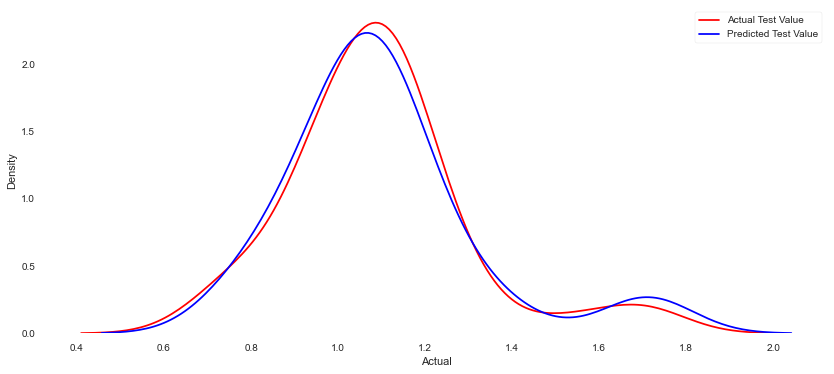

In [31]:
#trục quan hóa dữ liệu
final = pd.DataFrame({'Actual': y_test.values, 
                   'Prediction': pd.DataFrame(y_pred_XGB)[0].values}) 

plt.figure(figsize=(14,6))
ax1 = sns.kdeplot(final['Actual'], color='r', label='Actual Test Value')
sns.kdeplot(final['Prediction'], color='b', label='Predicted Test Value', ax=ax1)
plt.legend()
plt.show()

### Kết luận:
<b style="color:blue">Đối với Conventional Avocado tại California, XGBoost cho kết quả R2 cao nhất đại 91% và mức độ overfitting thấp nhất trong 3 mô hình, với MAE bằng với các mô hình còn lại (khoảng 5% so với mean của dữ liệu), biểu đồ cũng cho thấy mô hình dự đoán rất sát với thực tế => sử dụng XGBoost để dự đoán giá Conventional Avocado tại California</b>

# Yêu cầu 2: Bài Toán Dự Đoán Conventional Avocado tại California bằng ARIMA và Facebook Prophet

tới thời điểm này, chúng ta có thêm 1 góc nhìn khác để trả lời câu hỏi liệu California có khả năng phát triển kinh doanh bơ conventional trong năm tới không.

Để trả lời câu hỏi này, chúng ta tạm thời chưa bàn tới câu chuyện lợi nhuận kinh doanh vì trong dữ liệu không có, chúng ta sẽ xem xét xu hướng tăng của giá và doanh số bán hàng. Nếu cả 2 cùng tăng => có tiềm năng, nếu cả 2 cùng giảm => không tiềm năng, nhưng nếu cái tăng cái giảm thì sao???

Vì vậy, chúng ta cần tạo ra thêm biến <b>doanh thu trung bình = giá bán trung bình * doanh số, khi đó nếu doanh thu trung bình có xu hướng tăng => có tiềm năng, ngược lại là không tiềm năng</b>

#### Chuẩn bị dữ liệu

In [33]:
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,Month,Season
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California,12,3
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California,12,3
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California,12,3
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California,12,3
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California,11,2


In [34]:
df['AverageRevenue'] = df['AveragePrice'] * df['Total Volume']

In [35]:
df_cali = df[['Date','AverageRevenue']]
df_cali.head()

,Date,AverageRevenue
0,2015-12-27,4536328.92
1,2015-12-20,4413992.98
2,2015-12-13,4575638.24
3,2015-12-06,4504918.29
4,2015-11-29,4163896.66


In [37]:
df_cali.columns = ['ds','y']
df_cali.sort_values('ds', inplace=True)
df_cali.reset_index(inplace=True, drop=True)

In [38]:
df_cali.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      169 non-null    datetime64[ns]
 1   y       169 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.8 KB


#### Dùng ARIMA

In [39]:
df_cali.set_index('ds', inplace=True)
df_cali.head()

,y
ds,
2015-01-04,5372921.46
2015-01-11,5542937.75
2015-01-18,5682333.57
2015-01-25,5225677.32
2015-02-01,7677353.57


In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [43]:
result = seasonal_decompose(df_cali, model='mul')
result

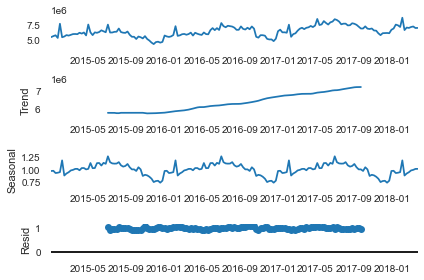

In [44]:
result.plot()
plt.show()

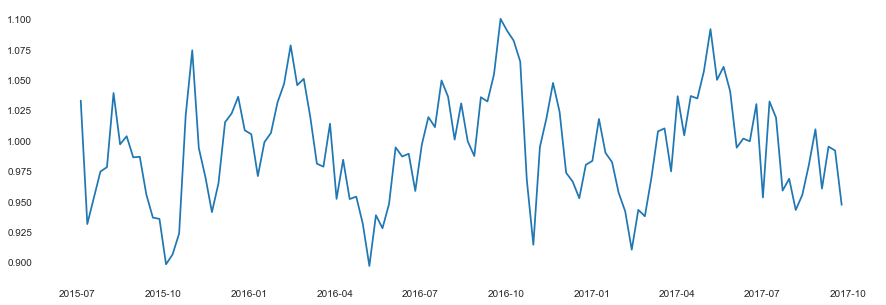

In [45]:
plt.figure(figsize=(15,5))
plt.plot(result.resid)
plt.show()

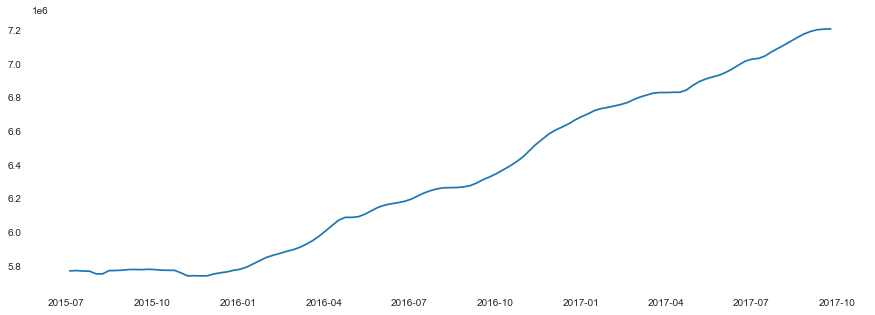

In [46]:
plt.figure(figsize=(15,5))
plt.plot(result.trend)
plt.show()

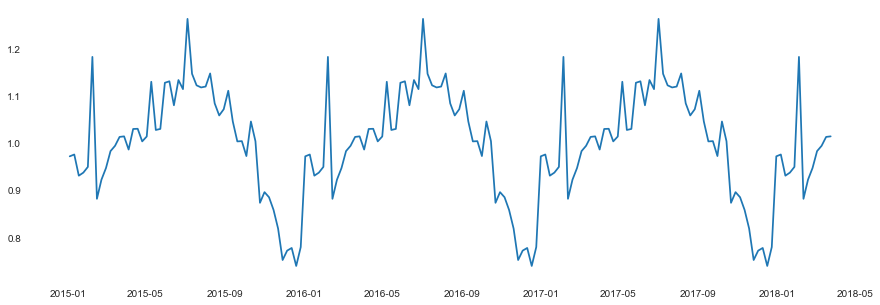

In [47]:
plt.figure(figsize=(15,5))
plt.plot(result.seasonal)
plt.show()

- Trend: dữ liệu có xu hướng đi ngang đến tháng 04-2016 thì bắt đầu xuất hiện xu hướng tăng mạnh
- Seasonal: dữ liệu có tính seasonal khá rõ qua từng năm
- Resid: lỗi tương đối ổn đỉnh ở mức 0.9 đến 1.1

In [48]:
stepwise_model = auto_arima(df_cali, start_p=2, start_q=2,
                           max_p=5, max_q=5, m=52,
                           start_P=1, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=40.43 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3450.492, Time=0.40 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3392.019, Time=4.46 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=3386.028, Time=5.50 sec
 ARIMA(0,1,1)(0,1,0)[52]             : AIC=3427.663, Time=0.38 sec
 ARIMA(0,1,1)(1,1,1)[52]             : AIC=3388.017, Time=9.71 sec
 ARIMA(0,1,1)(0,1,2)[52]             : AIC=3388.020, Time=11.36 sec
 ARIMA(0,1,1)(1,1,0)[52]             : AIC=3390.663, Time=5.16 sec
 ARIMA(0,1,1)(1,1,2)[52]             : AIC=inf, Time=36.83 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=3413.578, Time=4.54 sec
 ARIMA(1,1,1)(0,1,1)[52]             : AIC=3386.824, Time=8.83 sec
 ARIMA(0,1,2)(0,1,1)[52]             : AIC=inf, Time=7.62 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=3389.449, Time=5.58 sec
 ARIMA(1,1,2)(0,1,1)[52]             : AIC=inf, Time=14.64 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept 

In [49]:
df_cali.shape

(169, 1)

In [50]:
#chia dữ liệu 80-20
#tổng dữ liệu là 169 tuần => train 135 tuần test 34 tuần
train = df_cali.drop(df_cali.index[-34:])
train.tail()

,y
ds,
2017-07-02,8457334.54
2017-07-09,8319575.65
2017-07-16,8053733.62
2017-07-23,7575185.33
2017-07-30,7687981.32


In [51]:
test = df_cali.drop(df_cali.index[0:-34])
test.head()

,y
ds,
2017-08-06,7692098.87
2017-08-13,7386584.17
2017-08-20,7420958.48
2017-08-27,7760824.33
2017-09-03,7670385.06


In [52]:
stepwise_model.fit(train)

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 52),
      suppress_warnings=True, with_intercept=False)

In [53]:
future_forecast = stepwise_model.predict(n_periods=len(test))

In [54]:
mean_absolute_error(test['y'], future_forecast)

606697.1242465448

In [55]:
df_cali.y.mean()

6388388.938126035

In [56]:
test['y'].mean()

6939240.406655883

In [57]:
future_forecast = pd.DataFrame(future_forecast, index = test.index, columns=['Prediction'])
df_merge = test.join(future_forecast)
df_merge.tail()

,y,Prediction
ds,,
2018-02-25,6952872.30,8205439.21
2018-03-04,7113948.46,8423631.60
2018-03-11,7202352.03,8550579.83
2018-03-18,6938125.79,8647439.94
2018-03-25,6954489.82,8613531.71


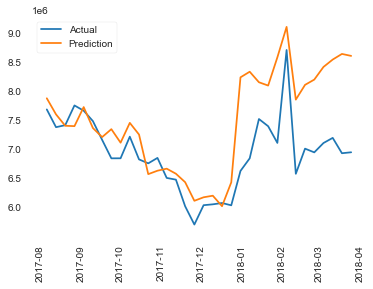

In [60]:
plt.plot(test, label='Actual')
plt.plot(future_forecast, label='Prediction')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

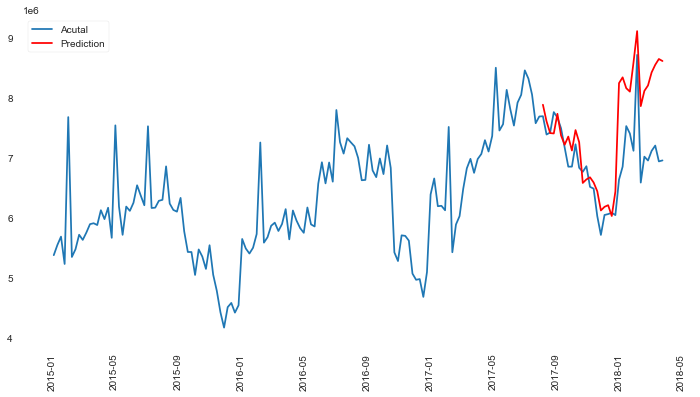

In [59]:
plt.figure(figsize=(12,6))
plt.plot(df_cali, label='Acutal')
plt.plot(future_forecast, label='Prediction', color='red')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

ARIMA dự báo gần khớp được xu hướng tăng giảm của dữ liệu, giá trị dự đoán có sự chênh lệch khoảng 10% so với thực tế (dựa trên MAE và mean của test và mean của dữ liệu)


#### ARIMA dự báo 1 năm kế tiếp

In [61]:
#next 52 weeks + 34 weeks test
future_forecast2 = stepwise_model.predict(n_periods=len(test)+52) 
future_forecast2

array([ 7884001.22708857,  7606885.50391165,  7410679.63325341,
        7404354.00206767,  7732708.1393621 ,  7371582.81869625,
        7216062.01536391,  7352410.781342  ,  7119707.97118383,
        7460753.14245634,  7259618.658461  ,  6578245.07430403,
        6637252.830519  ,  6672509.33323669,  6585425.21677495,
        6439753.01291102,  6119372.74896779,  6179742.22190482,
        6207029.88243503,  6026589.50074761,  6436821.45962513,
        8244559.59440126,  8341141.6086616 ,  8159918.4919868 ,
        8102907.75570941,  8588835.45686972,  9113222.53512391,
        7860762.41504195,  8115072.41284345,  8205439.21309756,
        8423631.59722314,  8550579.82659359,  8647439.9415499 ,
        8613531.70794337,  8619165.17173369,  8751655.06616176,
        8834981.93900008,  8632729.57401737,  9064687.26184902,
        9380247.50424208,  8798855.07608842,  8919290.5346349 ,
        9323480.22671516,  9312863.09384304,  9165507.77751835,
        9378620.7025754 ,  9316217.34700

In [62]:
#next 52 weeks
future_forecast2[len(test):]

array([ 8619165.17173369,  8751655.06616176,  8834981.93900008,
        8632729.57401737,  9064687.26184902,  9380247.50424208,
        8798855.07608842,  8919290.5346349 ,  9323480.22671516,
        9312863.09384304,  9165507.77751835,  9378620.7025754 ,
        9316217.34700463, 10039057.70346224,  9589452.08136914,
        9433936.60524444,  9331033.3753418 ,  9361038.39978466,
        9525866.11286089,  9248750.38968397,  9052544.51902572,
        9046218.88783999,  9374573.02513442,  9013447.70446857,
        8857926.90113623,  8994275.66711432,  8761572.85695615,
        9102618.02822866,  8901483.54423332,  8220109.96007635,
        8279117.71629132,  8314374.21900901,  8227290.10254727,
        8081617.89868335,  7761237.63474011,  7821607.10767714,
        7848894.76820735,  7668454.38651993,  8078686.34539745,
        9886424.48017358,  9983006.49443392,  9801783.37775912,
        9744772.64148173, 10230700.34264204, 10755087.42089623,
        9502627.30081427,  9756937.29861

In [63]:
import datetime
tail_week = datetime.datetime.strptime("2018-03-25","%Y-%m-%d")#ngày cuối cùng của dữ liệu
start_week = tail_week + datetime.timedelta(weeks=1) #tuần kế tiếp
end_week = start_week + datetime.timedelta(weeks=51) #51 tuần kế tiếp
weeks = pd.date_range(start_week,end_week, freq='W').strftime("%Y-%m-%d").tolist() 

In [64]:
new_predict = pd.DataFrame({'ds' : weeks,
                            'y': future_forecast2[len(test):]})
new_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      52 non-null     object 
 1   y       52 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes


In [65]:
new_predict['ds'] = pd.to_datetime(new_predict['ds'])
new_predict.set_index('ds', inplace=True)

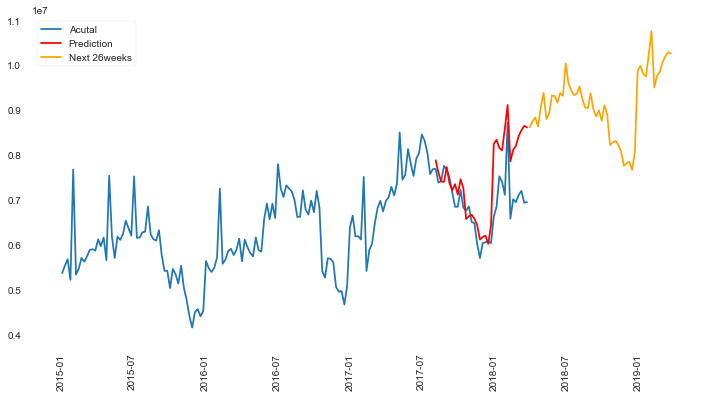

In [66]:
plt.figure(figsize=(12,6))
plt.plot(df_cali, label='Acutal')
plt.plot(future_forecast, label='Prediction', color='red')
plt.plot(new_predict, label='Next 26weeks', color='orange')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

chúng ta sẽ dùng biểu đồ này và MAE để so sánh với Facebook Prophet xem mô hình nào phù hợp hơn

#### Dùng Facebook Prophet

In [67]:
df_cali.head()

,y
ds,
2015-01-04,5372921.46
2015-01-11,5542937.75
2015-01-18,5682333.57
2015-01-25,5225677.32
2015-02-01,7677353.57


In [68]:
df_cali.reset_index(inplace=True)

In [69]:
df_cali.head()

,ds,y
0,2015-01-04,5372921.46
1,2015-01-11,5542937.75
2,2015-01-18,5682333.57
3,2015-01-25,5225677.32
4,2015-02-01,7677353.57


In [70]:
#chia dữ liệu 80-20
#tổng dữ liệu là 169 tuần => train 135 tuần test 34 tuần
train = df_cali.drop(df_cali.index[-34:])
train.tail()

,ds,y
130,2017-07-02,8457334.54
131,2017-07-09,8319575.65
132,2017-07-16,8053733.62
133,2017-07-23,7575185.33
134,2017-07-30,7687981.32


In [71]:
test = df_cali.drop(df_cali.index[0:-34])
test.head()

,ds,y
135,2017-08-06,7692098.87
136,2017-08-13,7386584.17
137,2017-08-20,7420958.48
138,2017-08-27,7760824.33
139,2017-09-03,7670385.06


In [72]:
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)

In [73]:
model.fit(train)

In [74]:
#34 tuần test và 17 tuần dự đoán
import datetime
start_week = datetime.datetime.strptime("2017-08-06","%Y-%m-%d")
end_week = start_week + datetime.timedelta(weeks=51)
weeks = pd.date_range(start_week,end_week, freq='W').strftime("%Y-%m-%d").tolist()
future = pd.DataFrame(weeks)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

In [75]:
future.tail()

,ds
47,2018-07-01
48,2018-07-08
49,2018-07-15
50,2018-07-22
51,2018-07-29


In [76]:
forecast = model.predict(future)

In [77]:
forecast[['ds','yhat']].head()

,ds,yhat
0,2017-08-06,7909682.72
1,2017-08-13,7882930.10
2,2017-08-20,7791528.87
3,2017-08-27,7705468.62
4,2017-09-03,7653637.35


In [78]:
forecast[['ds','yhat']].tail()

,ds,yhat
47,2018-07-01,9111535.32
48,2018-07-08,9095656.58
49,2018-07-15,8947145.08
50,2018-07-22,8820934.66
51,2018-07-29,8805563.05


In [79]:
df_cali.y.mean()

6388388.938126035

In [80]:
test.y.mean()

6939240.406655883

In [81]:
y_test = test['y'].values
y_pred = forecast['yhat'].values[:34]
mae_p = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % mae_p) 

MAE: 367369.810


In [82]:
rmse_p = sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % rmse_p)

RMSE: 463882.270


In [83]:
y_test_value = pd.DataFrame(y_test, index = pd.to_datetime(test['ds']),columns=['Actual'])
y_pred_value = pd.DataFrame(y_pred, index = pd.to_datetime(test['ds']),columns=['Prediction'])

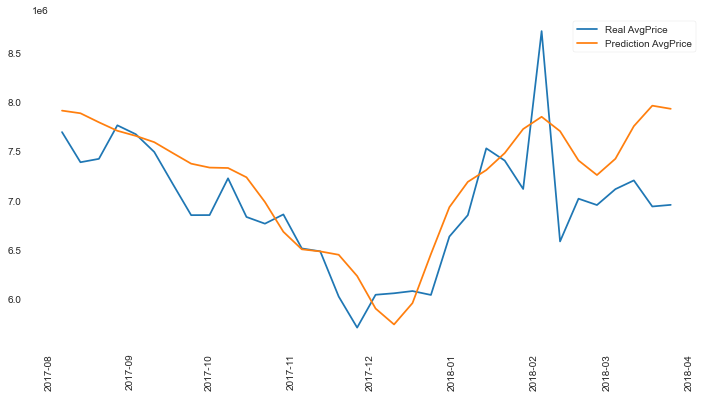

In [84]:
# Visulaize the result
plt.figure(figsize=(12,6))
plt.plot(y_test_value, label='Real AvgPrice')
plt.plot(y_pred_value, label='Prediction AvgPrice')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

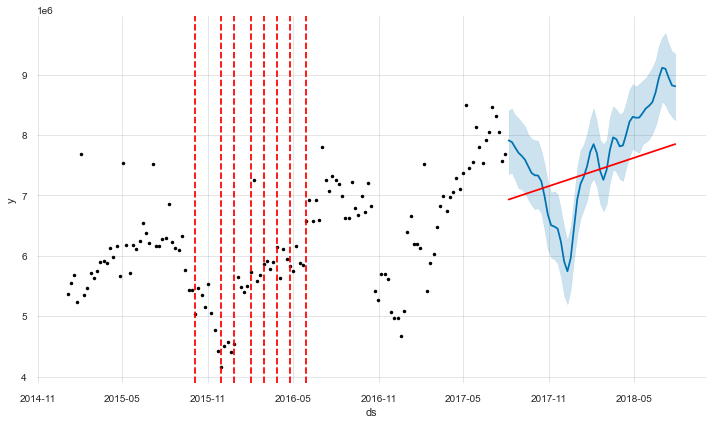

In [85]:
fig = model.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), model, forecast)

# Kết luận:

- MAE của ARIMA khoảng 10% so với mean của dữ liệu, MAE của FB Prophet khoảng 6% so với mean của dữ liệu, => có thể cân nhắc dùng được 2 thuật toán trên cho bộ dữ liệu này
- ARIMA tốn rất nhiều thời gian hơn so với FB Prophet vì phải chạy auto_arima để tìm ra bộ thông số phù hợp
- Do sự chênh lệch về MAE , và thời gian thực hiện của FB Prophet rất nhanh nên ta chọn FB Prophet để đự đoán giá theo seasonal

### Fb Prophet Dự đoán 1 năm kế tiếp

In [86]:
df_cali.head()

,ds,y
0,2015-01-04,5372921.46
1,2015-01-11,5542937.75
2,2015-01-18,5682333.57
3,2015-01-25,5225677.32
4,2015-02-01,7677353.57


In [91]:
m = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
m.fit(df_cali)
future = m.make_future_dataframe(periods=52*1, freq='W')

In [92]:
forecast = m.predict(future)

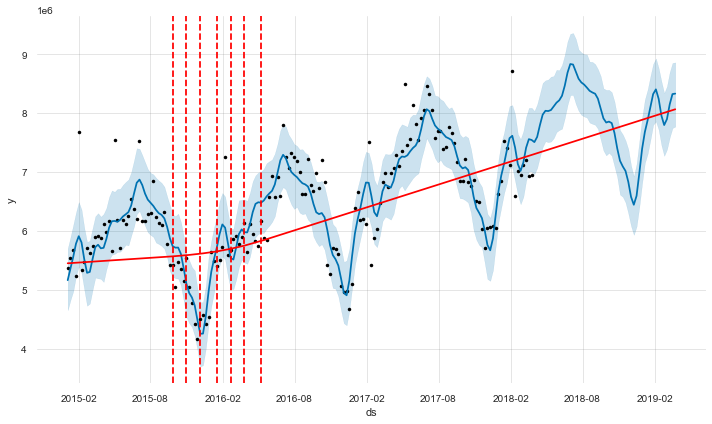

In [93]:
fig = m.plot(forecast)
fig.show()
a = add_changepoints_to_plot(fig.gca(), m, forecast)

<b style="color:blue"> So sánh với ARIMA khi dự báo 1 năm kế tiếp, ta thấy FB Prophet cho kết quả tốt hơn với MAE nhỏ hơn và xu hướng của mô hình dự đoán bám khá sát với dữ liệu lịch sử.</b>

<b style="color:blue"> Chúng ta nhận thấy có xu hướng tăng cho doanh thu trung bình của loại bơ conventional tại California trong 1 năm tới => có thể mở rộng kinh doanh bơ conventional tại California.</b>
